# Sequential Nearest-Neighbour Clustering

In [54]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


In [50]:
# load iris dataset
raw_iris = load_iris()
iris_data = raw_iris.data
iris = iris_data
iris = pd.DataFrame(raw_iris.data, columns = raw_iris.feature_names)
iris['target'] = raw_iris.target
iris.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Incremental Nearest Neighbors Clustering

In [51]:
class OnlineNrstNbr:
    def __init__(self, k, random_state=42):
        self.k = k
        self.centroids = None
        self.cluster_counts = None
        np.random.seed(random_state)

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        self.cluster_counts = np.ones(self.k)

    def predict(self, new_point):
        cluster_distances = np.zeros(self.k)
        for cluster in range(self.k):
            cluster_distances[cluster] = np.sqrt(np.sum((new_point - self.centroids[cluster])**2))
        return np.argmin(cluster_distances)

    def update(self, new_point):
        # add point as new cluster
        self.centroids = np.vstack([self.centroids, new_point])
        self.cluster_counts = np.append(self.cluster_counts, 1)

        # calculate distance between every pair of clusters
        # store the pair of centroids with smallest distance
        # replace the two centroids with one of them
        # repeat until k clusters remain
        while len(self.centroids) > self.k:
            cluster_distances = np.zeros((len(self.centroids), len(self.centroids)))
            for i in range(len(self.centroids)):
                for j in range(len(self.centroids)):
                    cluster_distances[i, j] = np.sqrt(np.sum((self.centroids[i] - self.centroids[j])**2))
            np.fill_diagonal(cluster_distances, np.inf) # set diagonal to infinity so we don't merge a cluster with itself
            c1, c2 = np.unravel_index(cluster_distances.argmin(), cluster_distances.shape) # find the indices of the smallest distance
            # calculate distance of new point to c1 and c2
            c1_dist = np.sqrt(np.sum((new_point - self.centroids[c1])**2))
            c2_dist = np.sqrt(np.sum((new_point - self.centroids[c2])**2))
            # merge the cluster with the smaller distance to the new point
            if c1_dist < c2_dist:
                c_parent = c1
                c_daughter = c2
            else:
                c_parent = c2
                c_daughter = c1
            # move points from more_points to fewer_points
            self.cluster_counts[c_parent] += self.cluster_counts[c_daughter]
            self.cluster_counts = np.delete(self.cluster_counts, c_daughter, axis=0)
            self.centroids = np.delete(self.centroids, c_daughter, axis=0)

    def plot_clusters(self, X):
        plt.scatter(X[:, 0], X[:, 1], c=np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2), axis=1), cmap='viridis')
        plt.title("Online Agglomerative Clustering")
        plt.xlabel("Sepal Length (cm)")
        plt.ylabel("Sepal Width (cm)")

        # Plot the cluster centers
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='red', s=200, label='Cluster Centers')
        plt.legend()
        plt.show()


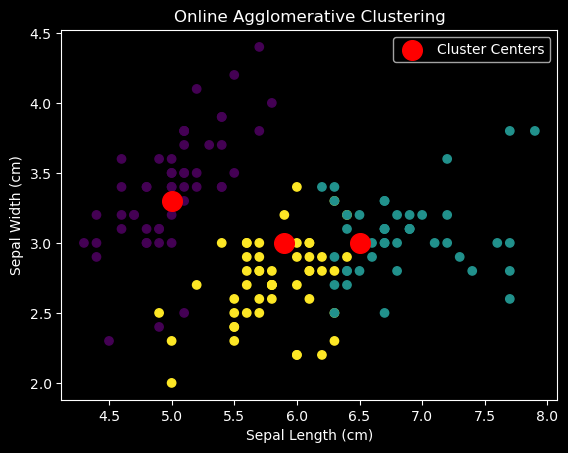

In [52]:
# Create an instance of the OnlineNrstNbr class
online_agg = OnlineNrstNbr(k=3, random_state=1)

# Initialize the centroids
online_agg.fit(iris_data)

# Loop through each data point and update the centroids
for point in iris_data:
    online_agg.update(point)

# Plot the final results
online_agg.plot_clusters(iris_data)


## SKLearn Agglomerative Clustering

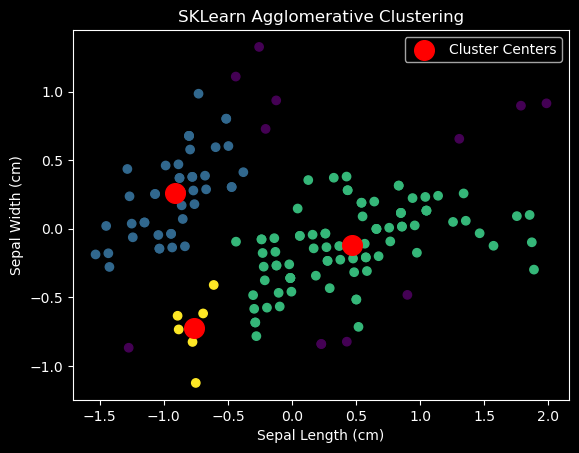

In [94]:
# Load the iris dataset
iris = load_iris()
X = iris.data[:, :2] # Use only the sepal length and sepal width

# Initialize the Nearest-Neighbors Clustering model
dbscan = DBSCAN(eps=0.3, min_samples=5)

# Fit the model to the data
dbscan.fit(X)

# Get the cluster assignments
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
k = len(set(labels)) - (1 if -1 in labels else 0)

# Reduce the dimensionality of the data for plotting
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot the data points with different colors for each cluster
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.title("SKLearn Agglomerative Clustering")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")

# Plot the cluster centers
cluster_centers = np.zeros((k, 2))
for i in range(k):
    cluster_centers[i] = X_reduced[labels == i].mean(axis=0)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, label='Cluster Centers')
plt.legend()

plt.show()
